## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [2]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Train data shape: ', (49000, 32, 32, 3))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 32, 32, 3))
('Validation labels shape: ', (1000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,1.0*np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = 1.0*correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for making how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [5]:
# Feel free to play with this cell

# [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
# [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
# [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
def my_model(X,y,is_training):
    y1 = tf.layers.conv2d(X, filters=64, kernel_size=[5, 5], strides=[1, 1], padding='same', activation=tf.nn.relu)
    y1 = tf.layers.max_pooling2d(y1, pool_size=[3, 3], strides=[2, 2])
    y1 = tf.layers.batch_normalization(y1, epsilon=1e-7, training=is_training)
    y1 = tf.layers.dropout(y1, rate=0.3, training=is_training)

    y2 = tf.layers.conv2d(y1, filters=64, kernel_size=[5, 5], strides=[1, 1], padding='same', activation=tf.nn.relu)
    y2 = tf.layers.max_pooling2d(y2, pool_size=[3, 3], strides=[2, 2])
    y2 = tf.layers.batch_normalization(y2, epsilon=1e-7, training=is_training)
    y2 = tf.layers.dropout(y2, rate=0.3, training=is_training)

    y3 = tf.layers.conv2d(y2, filters=128, kernel_size=[5, 5], strides=[1, 1], padding='same', activation=tf.nn.relu)
    y3 = tf.layers.max_pooling2d(y3, pool_size=[3, 3], strides=[2, 2])
    y3 = tf.layers.batch_normalization(y3, epsilon=1e-7, training=is_training)
    y3 = tf.layers.dropout(y3, rate=0.2, training=is_training)

    mp_vector = tf.contrib.layers.flatten(y3)
    y4 = tf.layers.dense(mp_vector, units=384, activation=tf.nn.relu)
    y4 = tf.layers.dropout(y4, rate=0.3, training=is_training)
    y5 = tf.layers.dense(y4, units=96, activation=tf.nn.relu)
    y5 = tf.layers.dropout(y5, rate=0.2, training=is_training)
    y_out = tf.layers.dense(y5, 10)
    return y_out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X, y, is_training)

mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.RMSPropOptimizer(1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

100 loops, best of 3: 8.07 ms per loop
(64, 10)
True


Training
Iteration 0: with minibatch training loss = 3.39 and accuracy of 0.094
Iteration 200: with minibatch training loss = 1.89 and accuracy of 0.36
Iteration 400: with minibatch training loss = 1.46 and accuracy of 0.47
Iteration 600: with minibatch training loss = 1.26 and accuracy of 0.56
Epoch 1, Overall loss = 1.65 and accuracy of 0.424


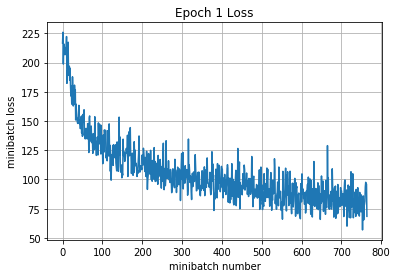

Iteration 800: with minibatch training loss = 1.26 and accuracy of 0.59
Iteration 1000: with minibatch training loss = 0.946 and accuracy of 0.66
Iteration 1200: with minibatch training loss = 1.3 and accuracy of 0.61
Iteration 1400: with minibatch training loss = 0.973 and accuracy of 0.72
Epoch 2, Overall loss = 1.14 and accuracy of 0.605


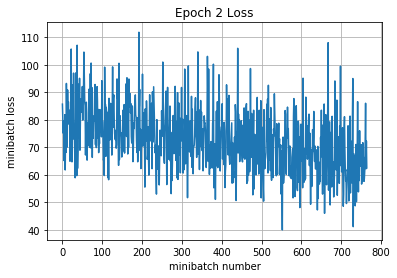

Iteration 1600: with minibatch training loss = 1.28 and accuracy of 0.53
Iteration 1800: with minibatch training loss = 0.949 and accuracy of 0.62
Iteration 2000: with minibatch training loss = 0.843 and accuracy of 0.72
Iteration 2200: with minibatch training loss = 0.861 and accuracy of 0.72
Epoch 3, Overall loss = 0.963 and accuracy of 0.671


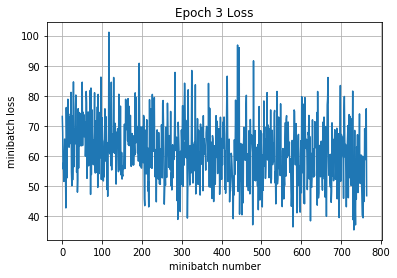

Iteration 2400: with minibatch training loss = 0.727 and accuracy of 0.73
Iteration 2600: with minibatch training loss = 0.759 and accuracy of 0.72
Iteration 2800: with minibatch training loss = 0.875 and accuracy of 0.72
Iteration 3000: with minibatch training loss = 0.599 and accuracy of 0.78
Epoch 4, Overall loss = 0.864 and accuracy of 0.706


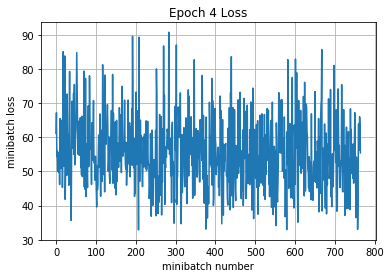

Iteration 3200: with minibatch training loss = 0.647 and accuracy of 0.77
Iteration 3400: with minibatch training loss = 0.919 and accuracy of 0.67
Iteration 3600: with minibatch training loss = 0.649 and accuracy of 0.77
Iteration 3800: with minibatch training loss = 0.637 and accuracy of 0.78
Epoch 5, Overall loss = 0.798 and accuracy of 0.732


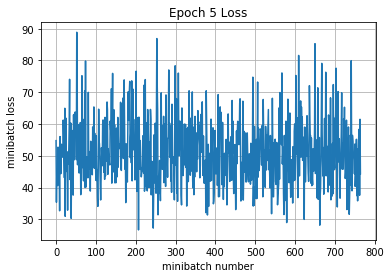

Iteration 4000: with minibatch training loss = 0.57 and accuracy of 0.83
Iteration 4200: with minibatch training loss = 0.733 and accuracy of 0.72
Iteration 4400: with minibatch training loss = 0.641 and accuracy of 0.77
Epoch 6, Overall loss = 0.762 and accuracy of 0.747


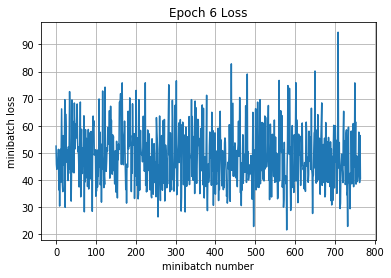

Iteration 4600: with minibatch training loss = 1.11 and accuracy of 0.61
Iteration 4800: with minibatch training loss = 0.533 and accuracy of 0.86
Iteration 5000: with minibatch training loss = 0.462 and accuracy of 0.81
Iteration 5200: with minibatch training loss = 0.693 and accuracy of 0.73
Epoch 7, Overall loss = 0.732 and accuracy of 0.753


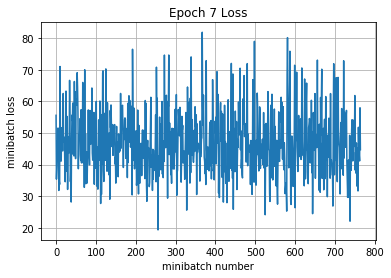

Iteration 5400: with minibatch training loss = 0.788 and accuracy of 0.8
Iteration 5600: with minibatch training loss = 0.53 and accuracy of 0.81
Iteration 5800: with minibatch training loss = 0.7 and accuracy of 0.81
Iteration 6000: with minibatch training loss = 0.713 and accuracy of 0.8
Epoch 8, Overall loss = 0.709 and accuracy of 0.766


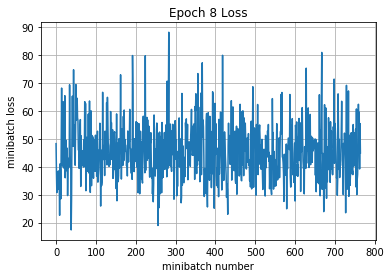

Iteration 6200: with minibatch training loss = 0.561 and accuracy of 0.81
Iteration 6400: with minibatch training loss = 0.585 and accuracy of 0.77
Iteration 6600: with minibatch training loss = 0.925 and accuracy of 0.77
Iteration 6800: with minibatch training loss = 0.598 and accuracy of 0.81
Epoch 9, Overall loss = 0.698 and accuracy of 0.773


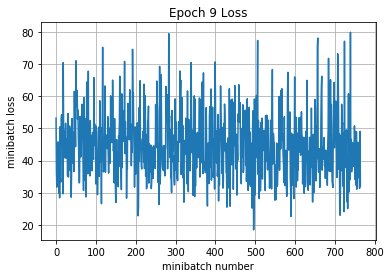

Iteration 7000: with minibatch training loss = 0.573 and accuracy of 0.78
Iteration 7200: with minibatch training loss = 0.595 and accuracy of 0.83
Iteration 7400: with minibatch training loss = 0.737 and accuracy of 0.7
Iteration 7600: with minibatch training loss = 0.461 and accuracy of 0.84
Epoch 10, Overall loss = 0.671 and accuracy of 0.778


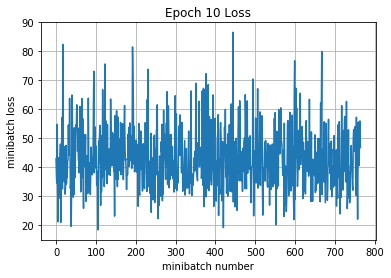

Iteration 7800: with minibatch training loss = 0.482 and accuracy of 0.83
Iteration 8000: with minibatch training loss = 0.885 and accuracy of 0.8
Iteration 8200: with minibatch training loss = 0.911 and accuracy of 0.73
Iteration 8400: with minibatch training loss = 0.821 and accuracy of 0.72
Epoch 11, Overall loss = 0.652 and accuracy of 0.785


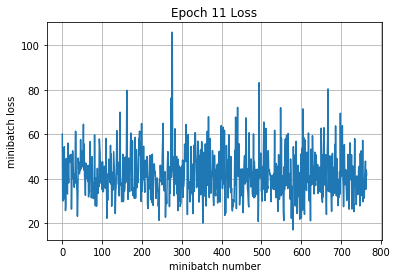

Iteration 8600: with minibatch training loss = 0.821 and accuracy of 0.73
Iteration 8800: with minibatch training loss = 0.756 and accuracy of 0.73
Iteration 9000: with minibatch training loss = 0.599 and accuracy of 0.81
Epoch 12, Overall loss = 0.635 and accuracy of 0.792


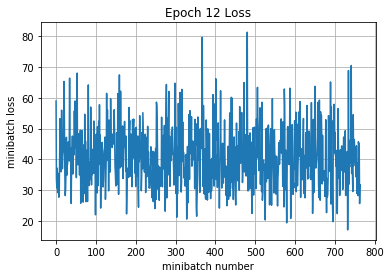

Iteration 9200: with minibatch training loss = 0.545 and accuracy of 0.81
Iteration 9400: with minibatch training loss = 0.656 and accuracy of 0.77
Iteration 9600: with minibatch training loss = 0.524 and accuracy of 0.91
Iteration 9800: with minibatch training loss = 0.715 and accuracy of 0.86
Epoch 13, Overall loss = 0.615 and accuracy of 0.798


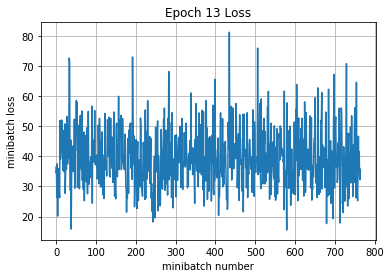

Iteration 10000: with minibatch training loss = 0.785 and accuracy of 0.73
Iteration 10200: with minibatch training loss = 0.529 and accuracy of 0.86
Iteration 10400: with minibatch training loss = 0.55 and accuracy of 0.77
Iteration 10600: with minibatch training loss = 0.502 and accuracy of 0.8
Epoch 14, Overall loss = 0.613 and accuracy of 0.8


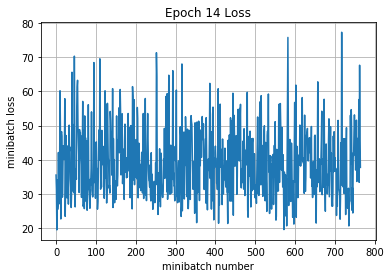

Iteration 10800: with minibatch training loss = 0.757 and accuracy of 0.77
Iteration 11000: with minibatch training loss = 0.378 and accuracy of 0.88
Iteration 11200: with minibatch training loss = 0.662 and accuracy of 0.78
Iteration 11400: with minibatch training loss = 0.337 and accuracy of 0.91
Epoch 15, Overall loss = 0.591 and accuracy of 0.808


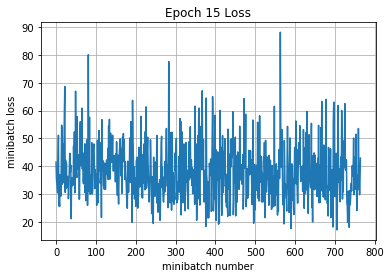

Iteration 11600: with minibatch training loss = 0.516 and accuracy of 0.84
Iteration 11800: with minibatch training loss = 0.595 and accuracy of 0.77
Iteration 12000: with minibatch training loss = 0.302 and accuracy of 0.88
Iteration 12200: with minibatch training loss = 0.494 and accuracy of 0.86
Epoch 16, Overall loss = 0.578 and accuracy of 0.811


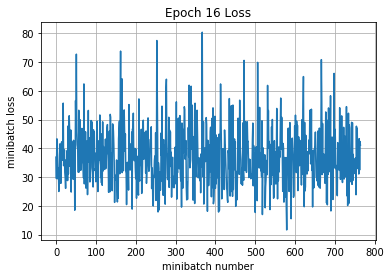

Iteration 12400: with minibatch training loss = 0.511 and accuracy of 0.8
Iteration 12600: with minibatch training loss = 0.575 and accuracy of 0.81
Iteration 12800: with minibatch training loss = 0.844 and accuracy of 0.75
Iteration 13000: with minibatch training loss = 0.667 and accuracy of 0.78
Epoch 17, Overall loss = 0.572 and accuracy of 0.817


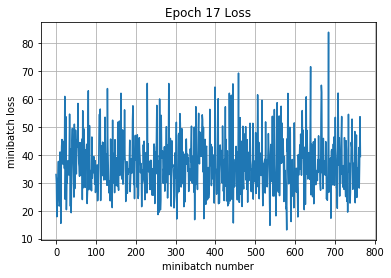

Iteration 13200: with minibatch training loss = 0.555 and accuracy of 0.81
Iteration 13400: with minibatch training loss = 0.3 and accuracy of 0.86
Iteration 13600: with minibatch training loss = 0.415 and accuracy of 0.86
Epoch 18, Overall loss = 0.557 and accuracy of 0.82


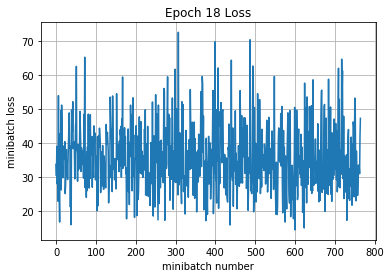

Iteration 13800: with minibatch training loss = 0.798 and accuracy of 0.73
Iteration 14000: with minibatch training loss = 0.677 and accuracy of 0.75
Iteration 14200: with minibatch training loss = 0.398 and accuracy of 0.88
Iteration 14400: with minibatch training loss = 0.537 and accuracy of 0.86
Epoch 19, Overall loss = 0.552 and accuracy of 0.821


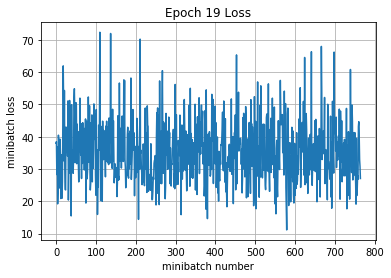

Iteration 14600: with minibatch training loss = 0.614 and accuracy of 0.8
Iteration 14800: with minibatch training loss = 0.274 and accuracy of 0.88
Iteration 15000: with minibatch training loss = 0.402 and accuracy of 0.88
Iteration 15200: with minibatch training loss = 0.776 and accuracy of 0.8
Epoch 20, Overall loss = 0.537 and accuracy of 0.827


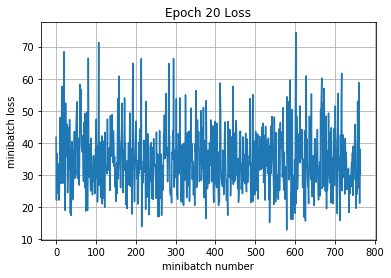

Iteration 15400: with minibatch training loss = 0.42 and accuracy of 0.86
Iteration 15600: with minibatch training loss = 0.593 and accuracy of 0.8
Iteration 15800: with minibatch training loss = 0.425 and accuracy of 0.84
Iteration 16000: with minibatch training loss = 0.513 and accuracy of 0.84
Epoch 21, Overall loss = 0.521 and accuracy of 0.831


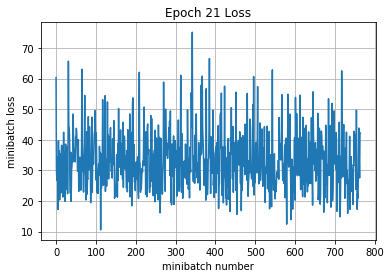

Iteration 16200: with minibatch training loss = 0.481 and accuracy of 0.83
Iteration 16400: with minibatch training loss = 0.354 and accuracy of 0.88
Iteration 16600: with minibatch training loss = 0.521 and accuracy of 0.84
Iteration 16800: with minibatch training loss = 0.464 and accuracy of 0.8
Epoch 22, Overall loss = 0.516 and accuracy of 0.834


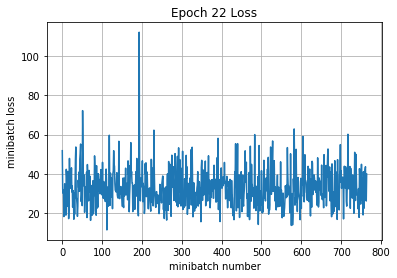

Iteration 17000: with minibatch training loss = 0.571 and accuracy of 0.78
Iteration 17200: with minibatch training loss = 0.51 and accuracy of 0.81
Iteration 17400: with minibatch training loss = 0.448 and accuracy of 0.84
Epoch 23, Overall loss = 0.502 and accuracy of 0.839


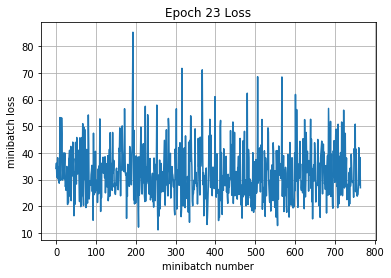

Iteration 17600: with minibatch training loss = 0.281 and accuracy of 0.89
Iteration 17800: with minibatch training loss = 0.54 and accuracy of 0.78
Iteration 18000: with minibatch training loss = 0.428 and accuracy of 0.84
Iteration 18200: with minibatch training loss = 0.727 and accuracy of 0.8
Epoch 24, Overall loss = 0.5 and accuracy of 0.84


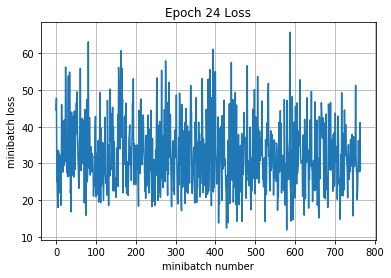

Iteration 18400: with minibatch training loss = 0.594 and accuracy of 0.81
Iteration 18600: with minibatch training loss = 0.278 and accuracy of 0.89
Iteration 18800: with minibatch training loss = 0.653 and accuracy of 0.83
Iteration 19000: with minibatch training loss = 0.277 and accuracy of 0.89
Epoch 25, Overall loss = 0.491 and accuracy of 0.844


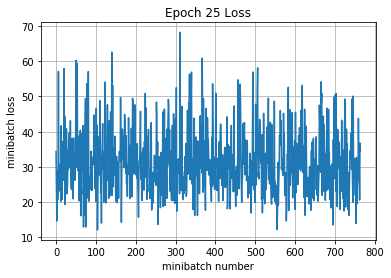

Iteration 19200: with minibatch training loss = 0.4 and accuracy of 0.89
Iteration 19400: with minibatch training loss = 0.383 and accuracy of 0.88
Iteration 19600: with minibatch training loss = 0.705 and accuracy of 0.8
Iteration 19800: with minibatch training loss = 0.344 and accuracy of 0.88
Epoch 26, Overall loss = 0.483 and accuracy of 0.846


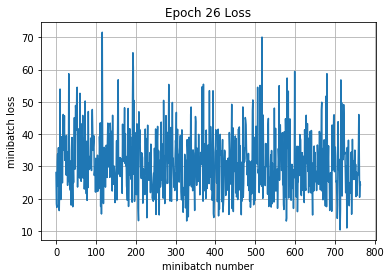

Iteration 20000: with minibatch training loss = 0.549 and accuracy of 0.73
Iteration 20200: with minibatch training loss = 0.624 and accuracy of 0.81
Iteration 20400: with minibatch training loss = 0.569 and accuracy of 0.75
Iteration 20600: with minibatch training loss = 0.461 and accuracy of 0.83
Epoch 27, Overall loss = 0.477 and accuracy of 0.845


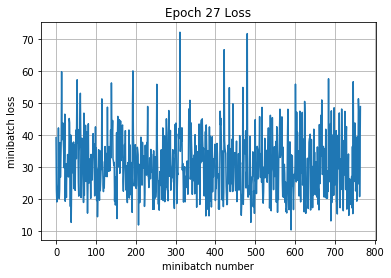

Iteration 20800: with minibatch training loss = 0.561 and accuracy of 0.88
Iteration 21000: with minibatch training loss = 0.479 and accuracy of 0.84
Iteration 21200: with minibatch training loss = 0.627 and accuracy of 0.81
Iteration 21400: with minibatch training loss = 0.317 and accuracy of 0.88
Epoch 28, Overall loss = 0.467 and accuracy of 0.849


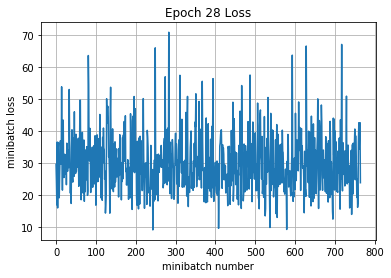

Iteration 21600: with minibatch training loss = 0.456 and accuracy of 0.86
Iteration 21800: with minibatch training loss = 0.292 and accuracy of 0.89
Iteration 22000: with minibatch training loss = 0.761 and accuracy of 0.78
Epoch 29, Overall loss = 0.457 and accuracy of 0.854


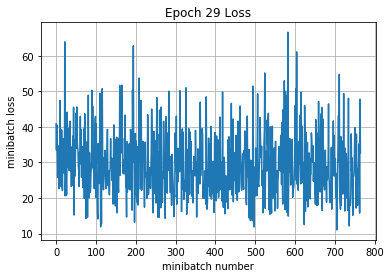

Iteration 22200: with minibatch training loss = 0.63 and accuracy of 0.78
Iteration 22400: with minibatch training loss = 0.385 and accuracy of 0.86
Iteration 22600: with minibatch training loss = 0.587 and accuracy of 0.83
Iteration 22800: with minibatch training loss = 0.636 and accuracy of 0.77
Epoch 30, Overall loss = 0.448 and accuracy of 0.856


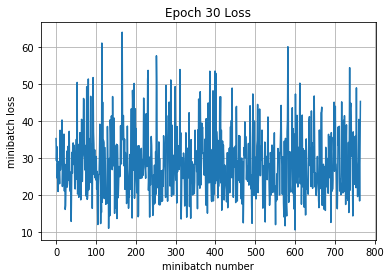

Validation
Epoch 1, Overall loss = 0.537 and accuracy of 0.801


(0.53711512565612796, 0.801)

In [7]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,30,64,200,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [8]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.225 and accuracy of 0.928
Validation
Epoch 1, Overall loss = 0.538 and accuracy of 0.801


(0.53830740356445317, 0.801)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [9]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 0.605 and accuracy of 0.822


(0.60493536052703856, 0.8219)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.